# Imports

In [1]:
import sys

from functools import total_ordering
from copy import deepcopy

from collections import deque
from heapq import *

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Define Process

In [2]:
@total_ordering
class Process:
    def __init__(self, id, arrive_time, burst_time):
        self.id = id
        self.arrive_time = arrive_time
        self.burst_time = burst_time
        self.predicted_burst_time = -1
        self.wait_start_time = arrive_time
        self.processed_time = 0
        
    # Question guarantees only one process arrives at a time
    def __eq__(self, other):
        if other == None:
            return False
        return self.arrive_time == other.arrive_time
    
    # Sort by burst_time for SRTF
    # Sort by predicted_burst_time for SJF
    def __lt__(self, other):
        if self.predicted_burst_time == -1:
            if self.burst_time != other.burst_time:
                return self.burst_time < other.burst_time
        else:
            if self.predicted_burst_time != other.predicted_burst_time:
                return self.predicted_burst_time < other.predicted_burst_time
        return self.arrive_time < other.arrive_time
        
    #for printing purpose
    def __repr__(self):
        return ('[id %d : arrive_time %d,  burst_time %d]'%(self.id, self.arrive_time, self.burst_time))

# Define Schedulers
* Input: process_list, [time_quantum (Positive Integer), alpha]
* Output_1 : Schedule list contains pairs of (time_stamp, proccess_id) indicating the time switching to that proccess_id
* Output_2 : Average Waiting Time


## First Come First Serve

In [3]:
def FCFS_scheduling(process_list):
    #store the (switching time, proccess_id) pair
    schedule = []
    current_time = 0
    waiting_time = 0
    for process in process_list:
        if(current_time < process.arrive_time):
            current_time = process.arrive_time
            
        schedule.append((current_time, process.id))
        waiting_time = waiting_time + (current_time - process.arrive_time)
        current_time = current_time + process.burst_time
    average_waiting_time = waiting_time / float(len(process_list))
    
    return schedule, average_waiting_time

In [4]:
process_list = [
    Process(0, 0, 9),
    Process(1, 1, 8),
    Process(2, 2, 2),
    Process(3, 5, 2)
]

schedule, avg = FCFS_scheduling(process_list)
print schedule
print avg

[(0, 0), (9, 1), (17, 2), (19, 3)]
9.25


## Round Robin
Scheduling process_list on round robin policy with time_quantum

In [5]:
def RR_scheduling(process_list, time_quantum ):
    process_list = deepcopy(process_list)
    n = float(len(process_list))
    
    schedule = []
    current_time = 0
    waiting_time = 0
    
    current_process = None
    queue = deque()
    
    while len(queue) > 0 or len(process_list) > 0:
        if len(queue) <= 0:
            # Handle time-gaps
            current_process = process_list[0]
            process_list = process_list[1:]
            current_time = current_process.arrive_time
            schedule.append((current_time, current_process.id))
        else:
            # RR process queue
            prev_process = current_process
            current_process = queue.popleft()
            if current_process.id != prev_process.id:
                prev_process.wait_start_time = current_time
                waiting_time = waiting_time + current_time - current_process.wait_start_time
                schedule.append((current_time, current_process.id))
        
        # If process finish early reclaim time, otherwise preempt at quanta
        process_time = min(
            time_quantum, 
            current_process.burst_time - current_process.processed_time)
        current_time = current_time + process_time
        
        # Process arrivals during quanta
        while len(process_list) > 0 and process_list[0].arrive_time <= current_time:
            queue.append(process_list[0])
            process_list = process_list[1:]
        
        # Re-enqueue current process if not finished
        current_process.processed_time = current_process.processed_time + process_time
        if current_process.processed_time < current_process.burst_time:
            queue.append(current_process)
    
    return (schedule, waiting_time / n)

In [6]:
process_list = [
    Process(0, 0, 9),
    Process(1, 1, 8),
    Process(2, 2, 2),
    Process(3, 5, 2)
]

schedule, avg = RR_scheduling(process_list, 2)
print schedule
print avg

[(0, 0), (2, 1), (4, 2), (6, 0), (8, 1), (10, 3), (12, 0), (14, 1), (16, 0), (18, 1), (20, 0)]
7.5


## Shortest Remaining Time First 
Scheduling process_list on SRTF, using process.burst_time to calculate the remaining time of the current process

In [7]:
def SRTF_scheduling(process_list):
    process_list = deepcopy(process_list)
    n = float(len(process_list))
    
    schedule = []
    current_time = 0
    waiting_time = 0
    
    current_process = None
    queue = []
    
    while current_process != None or len(queue) > 0 or len(process_list) > 0:
        if current_process == None:
            if len(queue) > 0:
                current_process = heappop(queue)
                waiting_time = waiting_time + current_time - current_process.wait_start_time
            else:
                # Handle time gaps
                current_process = process_list[0]
                process_list = process_list[1:]
                current_time = current_process.arrive_time
                
            schedule.append((current_time, current_process.id))
        
        # Advance time
        current_time = current_time + 1
        current_process.burst_time = current_process.burst_time - 1

        # Process arrivals
        if len(process_list) > 0 and process_list[0].arrive_time == current_time:
            # Preempt current process if new process is shorter
            if process_list[0].burst_time < current_process.burst_time:
                current_process.wait_start_time = current_time
                heappush(queue, current_process)
                current_process = process_list[0]
                schedule.append((current_time, current_process.id))
            else:
                heappush(queue, process_list[0])   
            process_list = process_list[1:]        
        
        # Remove process if finished
        if current_process.burst_time <= 0:
            current_process = None            

    return (schedule, waiting_time / n)

In [8]:
process_list = [
    Process(0, 0, 10),
    Process(1, 3, 5),
    Process(2, 7, 1),
    Process(3, 25, 10)
]

schedule, avg = SRTF_scheduling(process_list)
print schedule
print avg

[(0, 0), (3, 1), (8, 2), (9, 0), (25, 3)]
1.75


## Shortest Job First
Scheduling using future-predicting SJF without using information from process.burst_time

Initial guess = 5 time units

guess_n+1 = alpha \* burst_time_n + (1-alpha) \* guess_n

In [9]:
def SJF_scheduling(process_list, alpha):
    process_list = deepcopy(process_list)
    n = float(len(process_list))
    
    schedule = []
    current_time = 0
    waiting_time = 0
    
    current_process = None
    guesses = {}
    queue = []
    
    while len(queue) > 0 or len(process_list) > 0:
        if len(queue) <= 0:
            # Handle time-gaps
            current_process = process_list[0]
            process_list = process_list[1:]
            current_time = current_process.arrive_time
            schedule.append((current_time, current_process.id))
        else:
            # Find shortest job
            current_process = heappop(queue)
            waiting_time = waiting_time + current_time - current_process.wait_start_time
            schedule.append((current_time, current_process.id))
        
        # Process current procees till finish
        current_time = current_time + current_process.burst_time
        guesses[current_process.id] = alpha * current_process.burst_time + (1 - alpha) * guesses.get(current_process.id, 5)
        
        # Process arrivals during quanta
        while len(process_list) > 0 and process_list[0].arrive_time <= current_time:
            arrived_process = process_list[0]
            arrived_process.predicted_burst_time = guesses.get(arrived_process.id, 5)
            heappush(queue, process_list[0])
            process_list = process_list[1:]

    return (schedule, waiting_time / n)

In [10]:
process_list = [
    Process(0, 0, 10),
    Process(1, 3, 5),
    Process(2, 7, 1),
    Process(3, 25, 10)
]

schedule, avg = SJF_scheduling(process_list, 0.5)
print schedule
print avg

[(0, 0), (10, 1), (15, 2), (25, 3)]
3.75


# Read/Write Input/Output

In [11]:
def read_input(file_name):
    result = []
    with open(file_name) as f:
        for line in f:
            array = line.split()
            if (len(array)!= 3):
                print ("wrong input format")
                exit()
            result.append(Process(int(array[0]),int(array[1]),int(array[2])))
    return result

In [12]:
def write_output(file_name, schedule, avg_waiting_time):
    with open(file_name,'w') as f:
        for item in schedule:
            f.write(str(item) + '\n')
        f.write('average waiting time %.2f \n'%(avg_waiting_time))


# Task 1 Main Call

In [13]:
process_list = read_input('input.txt')
print ("printing input ----")
print '\n'.join(map(str, process_list))

print ("simulating FCFS ----")
FCFS_schedule, FCFS_avg_waiting_time =  FCFS_scheduling(process_list)
print '\n'.join(map(str, FCFS_schedule))
print FCFS_avg_waiting_time
write_output('FCFS.txt', FCFS_schedule, FCFS_avg_waiting_time )

print ("simulating RR ----")
RR_schedule, RR_avg_waiting_time =  RR_scheduling(process_list,time_quantum = 2)
print '\n'.join(map(str, RR_schedule))
print RR_avg_waiting_time
write_output('RR.txt', RR_schedule, RR_avg_waiting_time )

print ("simulating SRTF ----")
SRTF_schedule, SRTF_avg_waiting_time =  SRTF_scheduling(process_list)
print '\n'.join(map(str, SRTF_schedule))
print SRTF_avg_waiting_time
write_output('SRTF.txt', SRTF_schedule, SRTF_avg_waiting_time )

print ("simulating SJF ----")
SJF_schedule, SJF_avg_waiting_time =  SJF_scheduling(process_list, alpha = 0.5)
print '\n'.join(map(str, SJF_schedule))
print SJF_avg_waiting_time
write_output('SJF.txt', SJF_schedule, SJF_avg_waiting_time )

printing input ----
[id 0 : arrive_time 0,  burst_time 9]
[id 1 : arrive_time 1,  burst_time 8]
[id 2 : arrive_time 2,  burst_time 2]
[id 3 : arrive_time 5,  burst_time 2]
[id 3 : arrive_time 30,  burst_time 5]
[id 1 : arrive_time 31,  burst_time 2]
[id 2 : arrive_time 32,  burst_time 6]
[id 0 : arrive_time 38,  burst_time 8]
[id 2 : arrive_time 60,  burst_time 7]
[id 0 : arrive_time 62,  burst_time 2]
[id 1 : arrive_time 65,  burst_time 3]
[id 3 : arrive_time 66,  burst_time 8]
[id 1 : arrive_time 90,  burst_time 10]
[id 0 : arrive_time 95,  burst_time 10]
[id 2 : arrive_time 98,  burst_time 9]
[id 3 : arrive_time 99,  burst_time 8]
simulating FCFS ----
(0, 0)
(9, 1)
(17, 2)
(19, 3)
(30, 3)
(35, 1)
(37, 2)
(43, 0)
(60, 2)
(67, 0)
(69, 1)
(72, 3)
(90, 1)
(100, 0)
(110, 2)
(119, 3)
6.4375
simulating RR ----
(0, 0)
(2, 1)
(4, 2)
(6, 0)
(8, 1)
(10, 3)
(12, 0)
(14, 1)
(16, 0)
(18, 1)
(20, 0)
(30, 3)
(32, 1)
(34, 2)
(36, 3)
(38, 2)
(40, 0)
(42, 3)
(43, 2)
(45, 0)
(60, 2)
(62, 0)
(64, 2)
(66

# Task 2
## Question 1: Optimum Q and alpha for given input

10
6.4375
(0, 0)
(9, 1)
(17, 2)
(19, 3)
(30, 3)
(35, 1)
(37, 2)
(43, 0)
(60, 2)
(67, 0)
(69, 1)
(72, 3)
(90, 1)
(100, 0)
(110, 2)
(119, 3)


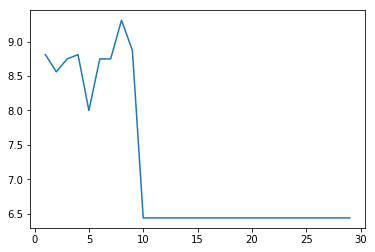

In [14]:
q_range = range(1, 30)

RR_avg_waiting_times = []
min_avg_time = 10000000
opt_q = -1 
opt_schedule = []
for Q in q_range:
    schedule, avg_waiting_time =  RR_scheduling(process_list,time_quantum = Q)
    RR_avg_waiting_times.append(avg_waiting_time)
    if min_avg_time > avg_waiting_time:
        min_avg_time = avg_waiting_time
        opt_q = Q
        opt_schedule = schedule
        
plt.plot(q_range, RR_avg_waiting_times)
print opt_q
print min_avg_time
print '\n'.join(map(str, opt_schedule))

0.0
6.4375
(0, 0)
(9, 1)
(17, 2)
(19, 3)
(30, 3)
(35, 1)
(37, 2)
(43, 0)
(60, 2)
(67, 0)
(69, 1)
(72, 3)
(90, 1)
(100, 0)
(110, 2)
(119, 3)


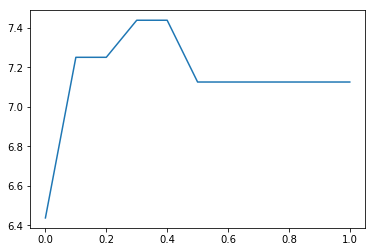

In [15]:
alpha_range = np.arange(0, 1.1, 0.1)

SJF_avg_waiting_times = []
min_avg_time = 10000000
opt_alpha = -1 
opt_schedule = []
for alpha in alpha_range:
    schedule, avg_waiting_time =  SJF_scheduling(process_list, alpha = alpha)
    SJF_avg_waiting_times.append(avg_waiting_time)
    if min_avg_time > avg_waiting_time:
        min_avg_time = avg_waiting_time
        opt_alpha = alpha
        opt_schedule = schedule

plt.plot(alpha_range, SJF_avg_waiting_times)
print opt_alpha
print min_avg_time
print '\n'.join(map(str, opt_schedule))

## Question 2: Optimal scheme for:
### a) All short processes

In [16]:
process_list = [
    Process(0, 0, 4),
    Process(1, 1, 3),
    Process(2, 2, 5),
    Process(3, 3, 3),
    Process(3, 4, 4),
    Process(1, 5, 3),
    Process(3, 6, 4),
    Process(2, 7, 5),
    Process(0, 8, 3),
    Process(1, 9, 2),
    Process(0, 10, 3),
    Process(0, 11, 3),
    Process(3, 12, 1),
    Process(2, 13, 2),
    Process(3, 14, 4),
    Process(1, 15, 2),
    Process(2, 16, 5),
    Process(0, 17, 5),
    Process(1, 18, 2),
    Process(3, 19, 2),
    Process(1, 20, 3)
]

5
22.4285714286
(0, 0)
(4, 1)
(7, 2)
(12, 3)
(19, 1)
(22, 3)
(26, 2)
(31, 0)
(34, 1)
(36, 0)
(42, 3)
(43, 2)
(45, 3)
(49, 1)
(51, 2)
(56, 0)
(61, 1)
(63, 3)
(65, 1)


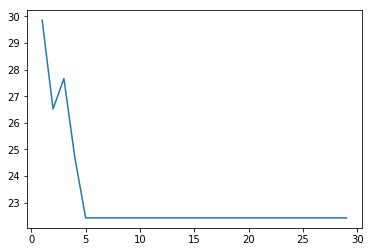

In [17]:
RR_avg_waiting_times = []
min_avg_time = 10000000
opt_q = -1 
opt_schedule = []
for Q in q_range:
    schedule, avg_waiting_time =  RR_scheduling(process_list,time_quantum = Q)
    RR_avg_waiting_times.append(avg_waiting_time)
    if min_avg_time > avg_waiting_time:
        min_avg_time = avg_waiting_time
        opt_q = Q
        opt_schedule = schedule
        
plt.plot(q_range, RR_avg_waiting_times)
print opt_q
print min_avg_time
print '\n'.join(map(str, opt_schedule))

0.1
21.7619047619
(0, 0)
(4, 1)
(7, 1)
(10, 1)
(12, 0)
(15, 1)
(17, 0)
(22, 1)
(24, 1)
(27, 0)
(30, 0)
(33, 2)
(38, 3)
(41, 3)
(45, 3)
(49, 2)
(54, 3)
(55, 2)
(57, 3)
(61, 2)
(66, 3)


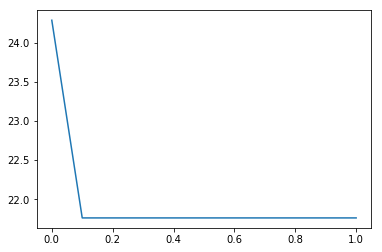

In [18]:
SJF_avg_waiting_times = []
min_avg_time = 10000000
opt_alpha = -1 
opt_schedule = []
for alpha in alpha_range:
    schedule, avg_waiting_time =  SJF_scheduling(process_list, alpha = alpha)
    SJF_avg_waiting_times.append(avg_waiting_time)
    if min_avg_time > avg_waiting_time:
        min_avg_time = avg_waiting_time
        opt_alpha = alpha
        opt_schedule = schedule

plt.plot(alpha_range, SJF_avg_waiting_times)
print opt_alpha
print min_avg_time
print '\n'.join(map(str, opt_schedule))

### b) Very short and very long processes interleaved

In [19]:
process_list = [
    Process(0, 0, 20),
    Process(1, 1, 3),
    Process(2, 2, 15),
    Process(3, 3, 3),
    Process(3, 4, 4),
    Process(1, 5, 3),
    Process(3, 6, 4),
    Process(2, 7, 25),
    Process(0, 8, 20),
    Process(1, 9, 2),
    Process(1, 10, 4),
    Process(0, 11, 13),
    Process(3, 12, 1),
    Process(2, 13, 20),
    Process(3, 14, 4),
    Process(1, 15, 2),
    Process(2, 16, 15),
    Process(0, 17, 25),
    Process(1, 18, 2),
    Process(3, 19, 2),
    Process(1, 20, 3)
]

10
66.4761904762
(0, 0)
(10, 1)
(13, 2)
(23, 3)
(30, 1)
(33, 3)
(37, 2)
(47, 0)
(57, 1)
(63, 0)
(83, 3)
(84, 2)
(94, 3)
(98, 1)
(100, 2)
(110, 0)
(120, 1)
(122, 3)
(124, 1)
(127, 2)
(142, 0)
(155, 2)
(170, 0)
(180, 2)
(185, 0)


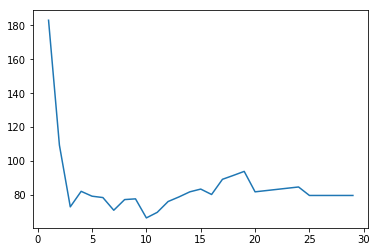

In [20]:
RR_avg_waiting_times = []
min_avg_time = 10000000
opt_q = -1 
opt_schedule = []
for Q in q_range:
    schedule, avg_waiting_time =  RR_scheduling(process_list,time_quantum = Q)
    RR_avg_waiting_times.append(avg_waiting_time)
    if min_avg_time > avg_waiting_time:
        min_avg_time = avg_waiting_time
        opt_q = Q
        opt_schedule = schedule
        
plt.plot(q_range, RR_avg_waiting_times)
print opt_q
print min_avg_time
print '\n'.join(map(str, opt_schedule))

0.1
72.9523809524
(0, 0)
(20, 1)
(23, 2)
(38, 3)
(41, 3)
(45, 1)
(48, 3)
(52, 2)
(77, 1)
(79, 1)
(83, 3)
(84, 2)
(104, 3)
(108, 1)
(110, 2)
(125, 1)
(127, 3)
(129, 1)
(132, 0)
(152, 0)
(165, 0)


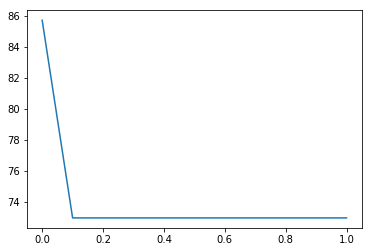

In [21]:
SJF_avg_waiting_times = []
min_avg_time = 10000000
opt_alpha = -1 
opt_schedule = []
for alpha in alpha_range:
    schedule, avg_waiting_time =  SJF_scheduling(process_list, alpha = alpha)
    SJF_avg_waiting_times.append(avg_waiting_time)
    if min_avg_time > avg_waiting_time:
        min_avg_time = avg_waiting_time
        opt_alpha = alpha
        opt_schedule = schedule

plt.plot(alpha_range, SJF_avg_waiting_times)
print opt_alpha
print min_avg_time
print '\n'.join(map(str, opt_schedule))